In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
import matplotlib.patches as mpatches

eggnog = pd.read_csv(r'D:\Uni\Dino\Projects\Sino\sym2\bin\scaffolds.fasta_dastool_output_DASTool_bins\contig2bin38\wo_16S\PROKKA_03012024\MM_y8vv8qgu.emapper.annotations.tsv', sep='\t', skiprows=4, skipfooter=3, engine='python')
fun=pd.read_csv(r'd:\Uni\Programmes\COG\fun.txt', sep='\t', header=None)
pseudo=pd.read_csv(r'D:\Uni\Dino\Projects\Sino\sym2\bin\scaffolds.fasta_dastool_output_DASTool_bins\contig2bin38\wo_16S\pseudofinder\output_intact.gff', sep='\t', header=None, skiprows=212)
intact = pd.read_csv(r'd:\Uni\Dino\Projects\Sino\CyanoGenome\Cyano_blob\missing3_per90_uni\edit3_final\pseudofinder\edit3_final_intact.emapper.annotations.tsv', sep='\t', skiprows=4, skipfooter=3, engine='python')

#Input for closest free-living relative
N_acidiphila_i = pd.read_csv(r'd:\Uni\Dino\Projects\Sino\sym2\bin\scaffolds.fasta_dastool_output_DASTool_bins\contig2bin38\GCA_024662015.1\pseudofinder\output_intact.emapper.annotations.tsv', sep='\t', skiprows=4, skipfooter=3, engine='python')
N_acidiphila_a = pd.read_csv(r'd:\Uni\Dino\Projects\Sino\sym2\bin\scaffolds.fasta_dastool_output_DASTool_bins\contig2bin38\GCA_024662015.1\protein.emapper.annotations.tsv', sep='\t', skiprows=4, skipfooter=3, engine='python')

COG annotation graph

In [8]:
#eggnog['COG'] = eggnog['eggNOG_OGs'].str.split('@').str.get(0)
eggnog['COG_category'] = eggnog['COG_category'].apply(list)
eggnog = eggnog.explode('COG_category')
eggnog_m = pd.merge(eggnog, fun, left_on='COG_category', right_on=1)[['#query','COG_category',0,2]]
fun_explanation = ("[" + eggnog_m['COG_category'].astype(str) + "] " + eggnog_m[2].astype(str)).drop_duplicates().sort_values()
pseudo[9] = pseudo[8].str.split('=').str.get(1)

COG annotation of plastid targeting genes(anyhit.txt) was done using http://eggnog-mapper.embl.de/

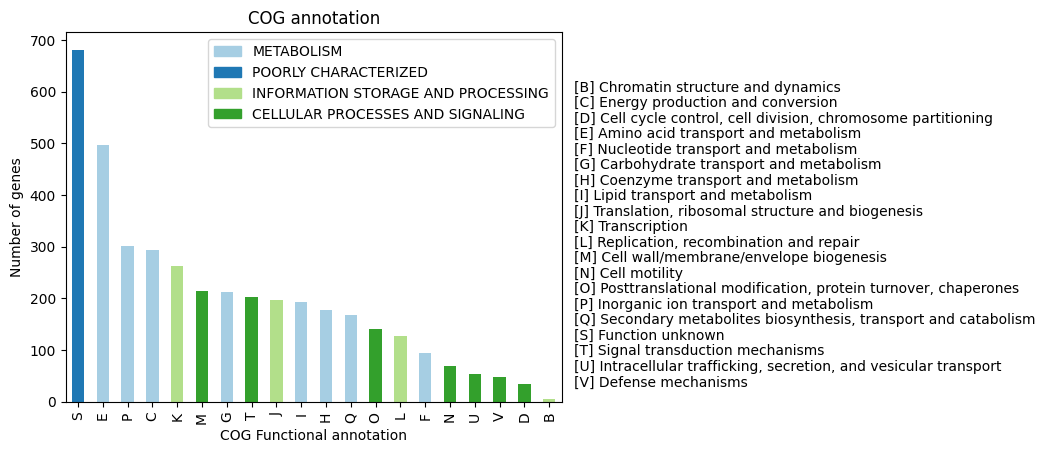

In [9]:
def plot_bargraph_with_groupings(df, groupby, colourby, title, xlabel, ylabel):
    """
    Plots a dataframe showing the frequency of datapoints grouped by one column and coloured by another.
    df : dataframe
    groupby: the column to groupby
    colourby: the column to color by
    title: the graph title
    xlabel: the x label,
    ylabel: the y label
    """
    # Makes a mapping from the unique colourby column items to a random color.
    ind_col_map = {x:y for x, y in zip(df[colourby].unique(),
                               [plt.cm.Paired(np.arange(len(df[colourby].unique())))][0])}

    # Find when the indicies of the soon to be bar graphs colors.
    unique_comb = df[[groupby, colourby]].drop_duplicates()
    name_ind_map = {x:y for x, y in zip(unique_comb[groupby], unique_comb[colourby])}
    c = df[groupby].value_counts().index.map(lambda x: ind_col_map[name_ind_map[x]])

    # Makes the bargraph.
    ax = df[groupby].value_counts().plot(kind='bar',
                                         title=title,
                                         color=c.values)
    # Makes a legend using the ind_col_map
    legend_list = []
    for key in ind_col_map.keys():
        legend_list.append(mpatches.Patch(color=ind_col_map[key], label=key))
    
    #add COG lables to side
    
    y=600
    x=20
    for i, explanation in enumerate(fun_explanation):
        plt.text(x, y-i*30, str(explanation))

    # display the graph.
    plt.legend(handles=legend_list, loc=0)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

plot_bargraph_with_groupings(eggnog_m,'COG_category',0,'COG annotation','COG Functional annotation','Number of genes')
plt.savefig("COG.svg")

In [10]:
#run with Symbiont
intact['COG_category'] = intact['COG_category'].apply(list)
intact = intact.explode('COG_category')
intact_m = pd.merge(intact, fun, left_on='COG_category', right_on=1)[['#query','COG_category',0,2]]

#run with N. acidiphila
N_acidiphila_i['COG_category'] = N_acidiphila_i['COG_category'].apply(list)
N_acidiphila_i = N_acidiphila_i.explode('COG_category')
N_acidiphila_i_m = pd.merge(N_acidiphila_i, fun, left_on='COG_category', right_on=1)[['#query','COG_category',0,2]]
N_acidiphila_a['COG_category'] = N_acidiphila_a['COG_category'].apply(list)
N_acidiphila_a = N_acidiphila_a.explode('COG_category')
N_acidiphila_a_m = pd.merge(N_acidiphila_a, fun, left_on='COG_category', right_on=1)[['#query','COG_category',0,2]]

Counting how many pseudogenes vs intact for each COG

In [26]:
df_counts_i = pd.merge(
    pd.DataFrame(
        intact_m['COG_category'].value_counts().reset_index().values, columns=['COG_category', 'Count']), 
        fun, 
        left_on='COG_category', right_on=1)[['COG_category', 'Count', 0, 2]]

df_counts_e = pd.merge(
    pd.DataFrame(
        eggnog_m['COG_category'].value_counts().reset_index().values, columns=['COG_category', 'Count']), 
        fun, 
        left_on='COG_category', right_on=1)[['COG_category', 'Count', 0, 2]]

df_diff = df_counts_i.merge(df_counts_e, on='COG_category', suffixes=('_i', '_e'), how='outer')
df_diff['Count_Diff'] = df_diff['Count_e'].fillna(0) - df_diff['Count_i'].fillna(0)
df_diff['percent']= (df_diff['Count_e'].fillna(0) - df_diff['Count_i'].fillna(0)) / df_diff['Count_e'].fillna(0) *100
df_diff[['COG_category', 'Count_i', 'Count_e', 'percent', '0_e', '2_e']].to_csv('percent_pseudo.csv', index=False)


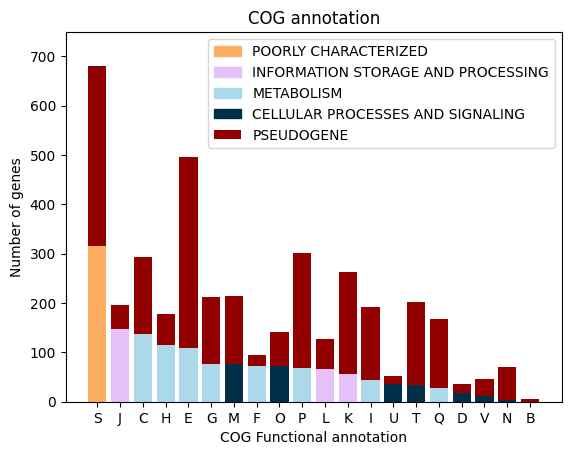

In [12]:
def plot_pseudos(df, groupby, colourby, total_count, pseudo_count, title, xlabel, ylabel):
    # Grouping data by the specified column
    grouped_data = df.groupby(groupby)[total_count].sum()
    pseudo_data = df.groupby(groupby)[pseudo_count].sum()

    # Calculating the difference between total and pseudo counts
    difference_data = grouped_data - pseudo_data

    # Sorting x-values based on the difference
    sorted_index = difference_data.sort_values(ascending=False).index
    grouped_data = grouped_data.loc[sorted_index]
    pseudo_data = pseudo_data.loc[sorted_index]

    # Getting unique categories for colourby column
    unique_categories = df[colourby].unique()
    
    # Using palette for colorblind-friendly colors
    cud_palette = ['#fdae61', '#e4c1f9', '#abd9e9', '#003049', '#0072B2', '#D55E00', '#CC79A7']
    
    # Creating a color dictionary for legend
    df = df.set_index(groupby).loc[sorted_index].reset_index()
    color_dict = dict(zip(unique_categories, cud_palette[:len(unique_categories)]))
    
    # Plotting
    fig, ax = plt.subplots()
    
    # Plotting bars for counts
    bars_total = ax.bar(grouped_data.index, grouped_data.values, color=[color_dict[cat] for cat in df[colourby]])
    bars_pseudo = ax.bar(grouped_data.index, -pseudo_data[grouped_data.index], bottom=grouped_data.values, color='#920000')
    
    # Adding labels and title
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_ylim(0, max(grouped_data.max(), pseudo_data.max()) * 1.1)

    # Adding legend
    legend_handles = [plt.Rectangle((0,0),1,1, color=color_dict[cat]) for cat in unique_categories]
    legend_handles.append(plt.Rectangle((0,0),1,1, facecolor='#920000'))  # For pseudo_count
    ax.legend(legend_handles, list(unique_categories) + ['PSEUDOGENE'])

plot_pseudos(df_diff,'COG_category','0_e', 'Count_e', 'Count_Diff', 'COG annotation','COG Functional annotation','Number of genes')
plt.savefig("COG_pseudo.svg")

Repeat with N. acidiphila

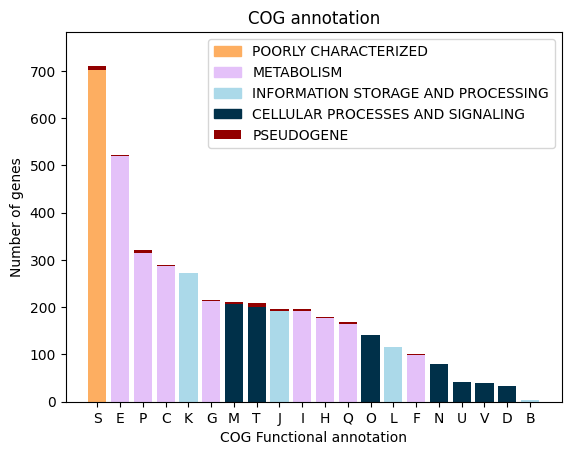

In [13]:
N_a_counts_i = pd.merge(
    pd.DataFrame(
        N_acidiphila_i_m['COG_category'].value_counts().reset_index().values, columns=['COG_category', 'Count']), 
        fun, 
        left_on='COG_category', right_on=1)[['COG_category', 'Count', 0, 2]]

N_a_counts_e = pd.merge(
    pd.DataFrame(
        N_acidiphila_a_m['COG_category'].value_counts().reset_index().values, columns=['COG_category', 'Count']), 
        fun, 
        left_on='COG_category', right_on=1)[['COG_category', 'Count', 0, 2]]

N_a_diff = N_a_counts_i.merge(N_a_counts_e, on='COG_category', suffixes=('_i', '_e'), how='outer')
N_a_diff['Count_Diff'] = N_a_diff['Count_e'].fillna(0) - N_a_diff['Count_i'].fillna(0)

#run plot
plot_pseudos(N_a_diff,'COG_category','0_e', 'Count_e', 'Count_Diff', 'COG annotation','COG Functional annotation','Number of genes')

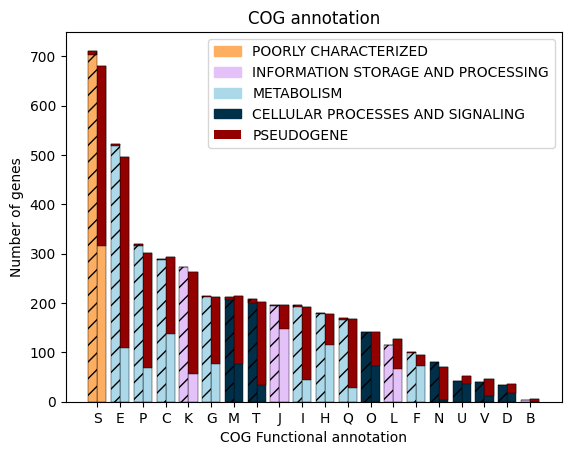

In [14]:
def plot_pseudos(df1, df2, groupby, colourby, total_count, pseudo_count, title, xlabel, ylabel):
    # Grouping data by the specified column
    grouped_data_df1 = df1.groupby(groupby)[total_count].sum()
    pseudo_data_df1 = df1.groupby(groupby)[pseudo_count].sum()
    grouped_data_df2 = df2.groupby(groupby)[total_count].sum()
    pseudo_data_df2 = df2.groupby(groupby)[pseudo_count].sum()

    # Sorting x-values based on the difference
    sorted_index_df1 = grouped_data_df2.sort_values(ascending=False).index
    grouped_data_df1 = grouped_data_df1.loc[sorted_index_df1]
    pseudo_data_df1 = pseudo_data_df1.loc[sorted_index_df1]

    # Sorting df2 groups by df1 order
    grouped_data_df2 = grouped_data_df2.reindex(sorted_index_df1)
    pseudo_data_df2 = pseudo_data_df2.reindex(sorted_index_df1)

    # Getting unique categories for colourby column
    unique_categories_df1 = df1[colourby].unique()
    unique_categories_df2 = df2[colourby].unique()
    
    # Using palette for colorblind-friendly colors
    cud_palette = ['#fdae61', '#e4c1f9', '#abd9e9', '#003049', '#0072B2', '#D55E00', '#CC79A7']
    
    # Creating a color dictionary for legend
    df1 = df1.set_index(groupby).loc[sorted_index_df1].reset_index()

    color_dict = dict(zip(unique_categories_df1, cud_palette[:len(unique_categories_df1)]))
    
    # Resetting index to ensure numerical indices
    grouped_data_df2 = grouped_data_df2.reset_index(drop=True)
    
    # Plotting
    fig, ax = plt.subplots()
    
    # Plotting bars for counts
    bars_total = ax.bar(grouped_data_df1.index, 
                        grouped_data_df1.values,  
                        align="edge", width=0.4, 
                        edgecolor='#000000',linewidth=0.3,
                        color=[color_dict[cat] for cat in df1[colourby]])
    bars_pseudo = ax.bar(grouped_data_df1.index, 
                         -pseudo_data_df1[grouped_data_df1.index], 
                         bottom=grouped_data_df1.values,
                         align="edge",width=0.4, 
                         color='#920000',
                         edgecolor='#000000',linewidth=0.3)
    bars_total = ax.bar(grouped_data_df2.index, 
                        grouped_data_df2.values, 
                        align="edge",width=-0.4, 
                        edgecolor='#000000',linewidth=0.3, hatch ='//',
                        color=[color_dict[cat] for cat in df1[colourby]])
    bars_pseudo = ax.bar(grouped_data_df2.index, 
                         -pseudo_data_df2[grouped_data_df2.index], 
                         align="edge",width=-0.4, 
                         bottom=grouped_data_df2.values, 
                         color='#920000',
                         edgecolor='#000000', hatch ='//',linewidth=0.3)
    
    # Adding labels and title
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_ylim(0, max(grouped_data_df1.max(), pseudo_data_df1.max()) * 1.1)

    # Adding legend
    legend_handles = [plt.Rectangle((0,0),1,1, color=color_dict[cat]) for cat in unique_categories_df1]
    legend_handles.append(plt.Rectangle((0,0),1,1, facecolor='#920000'))  # For pseudo_count
    ax.legend(legend_handles, list(unique_categories_df1) + ['PSEUDOGENE'])

plot_pseudos(df_diff,N_a_diff, 'COG_category','0_e', 'Count_e', 'Count_Diff', 'COG annotation','COG Functional annotation','Number of genes')
plt.savefig("COG_compare.svg")

Sanity check for symbiont pseudogene counts
-----

Numbers of each COG category in total

In [15]:
# Get unique values and their counts from 'merged' DataFrame
unique, counts = np.unique(eggnog_m[0], return_counts=True)
# Create a NumPy array from unique values and their counts
cog_count = np.array([unique, counts])

# Create a DataFrame from the NumPy array
cog_count_df = pd.DataFrame(cog_count.T, columns=['unique', 'counts'])
lables = cog_count_df['unique']
print(cog_count_df)

                               unique counts
0    CELLULAR PROCESSES AND SIGNALING    762
1  INFORMATION STORAGE AND PROCESSING    593
2                          METABOLISM   1935
3                POORLY CHARACTERIZED    681


Numbers of each COG catergory in intact 

In [16]:
# Get unique values and their counts from 'merged' DataFrame
unique, counts = np.unique(intact_m[0], return_counts=True)
# Create a NumPy array from unique values and their counts
cog_count = np.array([unique, counts])

# Create a DataFrame from the NumPy array
cog_count_df = pd.DataFrame(cog_count.T, columns=['unique', 'counts'])
lables = cog_count_df['unique']
print(cog_count_df)

                               unique counts
0    CELLULAR PROCESSES AND SIGNALING    251
1  INFORMATION STORAGE AND PROCESSING    270
2                          METABOLISM    648
3                POORLY CHARACTERIZED    315
